# Example 3 - RFLO VMR

Created: November 19, 2021

The goal here is to simulate a VisuoMotor Rotation (VMR) type experiment, which is very common in the nonhuman primate literature.

Here is how I change the task so that the targets are rotated:
```
theta = np.pi/8
R = np.ones((2,2))
R[0,0]=np.cos(theta)
R[0,1]=-np.sin(theta)
R[1,0]=np.sin(theta)
R[1,1]=np.cos(theta)
task1r = Task(x_in=x_pulse1, y_target = R @ np.asarray([[1],[1]]))
task2r = Task(x_in=x_pulse2, y_target = R @ np.asarray([[-1],[1]]))
task3r = Task(x_in=x_pulse3, y_target = R @ np.asarray([[1],[-1]]))
task4r = Task(x_in=x_pulse4, y_target = R @ np.asarray([[-1],[-1]]))
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.5

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### 1. Training all weights of network

7it [00:00, 69.26it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.05
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: True
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 10
dt_vel: 0.05
rng: <mtrand.RandomState object at 0x7ff8e6f30e58>


500it [00:01, 267.10it/s]


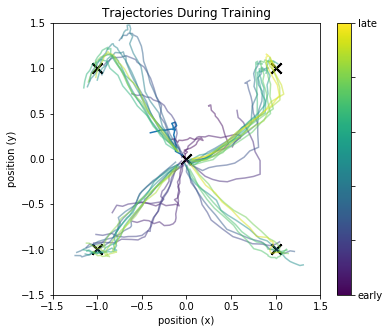

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
               sig_in=0.0,sig_rec=0.05,sig_out=0.01, sig_fb=0.01,
               velocity_transform=False, tau_vel = 10, dt_vel = 0.05,
               driving_feedback=True,
               rng=np.random.RandomState(1))
params.print_params()

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)


# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_rec','w_out','w_fb']) 
sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

# rflo = RFLO(net,apply_to=['w_rec']) 
# sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

# rflo = RFLO(net,apply_to=['w_fb'],online=False) 
# sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=50)



We can also plot the trained trajectories

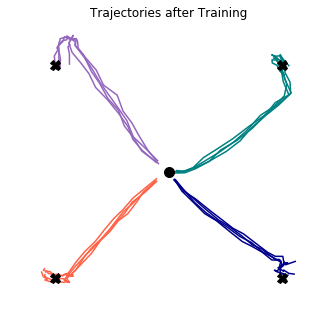

In [5]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


## Training `w_fb` only, with Rotated targets

In [6]:
theta = np.pi/8
R = np.ones((2,2))
R[0,0]=np.cos(theta)
R[0,1]=-np.sin(theta)
R[1,0]=np.sin(theta)
R[1,1]=np.cos(theta)
task1r = Task(x_in=x_pulse1, y_target = R @ np.asarray([[1],[1]]))
task2r = Task(x_in=x_pulse2, y_target = R @ np.asarray([[-1],[1]]))
task3r = Task(x_in=x_pulse3, y_target = R @ np.asarray([[1],[-1]]))
task4r = Task(x_in=x_pulse4, y_target = R @ np.asarray([[-1],[-1]]))

11it [00:00, 102.51it/s]

apply_to :  ['w_fb']
online :  True
weight_transport :  True


100it [00:00, 281.71it/s]


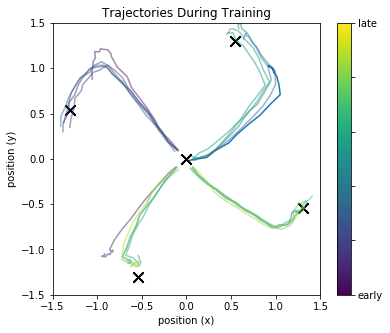

In [7]:
rflo = RFLO(net,apply_to=['w_fb']) 
rflo.print_params()
sim.run_session(n_trials=100, tasks=[task1r,task2r,task3r,task4r], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=5)


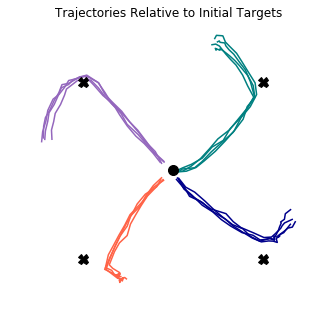

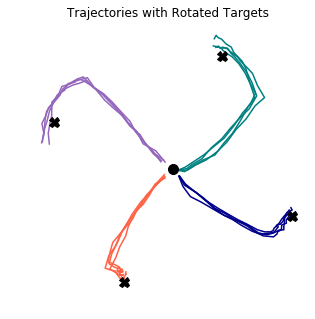

In [8]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Trajectories Relative to Initial Targets')
fig = plot_trained_trajectories(sim=sim, tasks=[task1r,task2r,task3r,task4r],title='Trajectories with Rotated Targets')



# 2. Training all weights of network, with velocity transform

5it [00:00, 48.72it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.1
tau_rec: 8
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: True
eta_fb: 0.5
sig_fb: 0.1
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.05
rng: <mtrand.RandomState object at 0x7ff8e6f30d38>


500it [00:01, 277.62it/s]
500it [00:01, 324.47it/s]


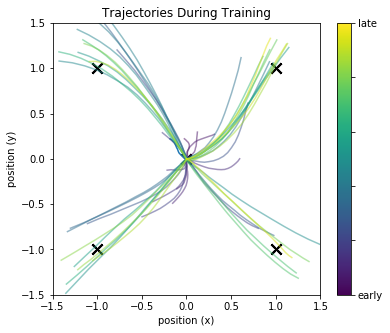

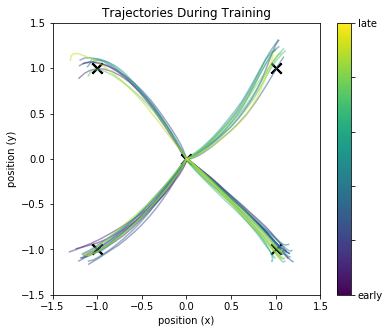

In [9]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
               sig_in=0.0,sig_rec=0.1,sig_out=0.1, sig_fb=0.1,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.05,
               driving_feedback=True,
               rng=np.random.RandomState(1))
params.print_params()

# Initialize RNN
net = RNN(params)

# initialize simulation
sim = Simulation(net)


# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_rec','w_out','w_fb']) 
sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

# for update rule, ensure credit assignment is transpose of w_out
net.set_weights(w_m=np.copy(net.w_out).T)
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_rec','w_fb']) 
sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

# rflo = RFLO(net,apply_to=['w_rec']) 
# sim.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

# rflo = RFLO(net,apply_to=['w_fb'],online=False) 
# sim.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=50)



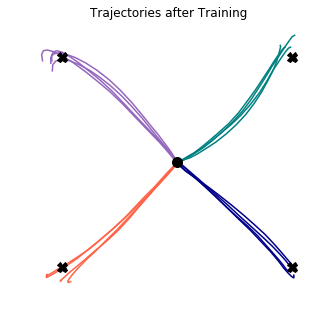

In [10]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4])


11it [00:00, 104.93it/s]

apply_to :  ['w_rec']
online :  True
weight_transport :  True


1000it [00:03, 284.29it/s]


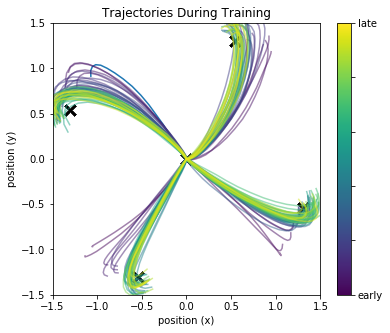

In [11]:
rflo = RFLO(net,apply_to=['w_rec'],online=True) 
rflo.print_params()
sim.run_session(n_trials=1000, tasks=[task1r,task2r,task3r,task4r], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=5)


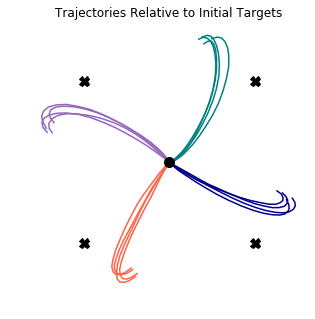

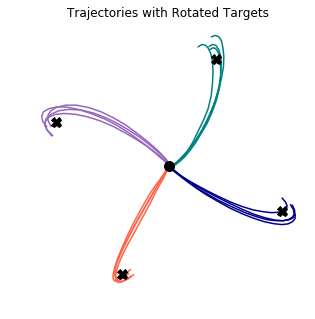

In [12]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1,task2,task3,task4],title='Trajectories Relative to Initial Targets')
fig = plot_trained_trajectories(sim=sim, tasks=[task1r,task2r,task3r,task4r],title='Trajectories with Rotated Targets')
